In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.6em;
line-height:1.4em
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.3em;
line-height:1.4em;
padding-right:3em;
}
</style>
""")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from itertools import cycle, islice
import pylab as pl
import operator
import re
from collections import OrderedDict
import pickle
import matplotlib.colors as colors
import math

Populating the interactive namespace from numpy and matplotlib


# Data Story: Fraud within the Affordable Care Act Premium Tax Credit
In this notebook, I examined data for tax returns submitted with claims for the Premium Tax Credit (PTC)https://www.irs.gov/affordable-care-act/individuals-and-families/the-premium-tax-credit. As a result of the Affordable Care (ACT), qualifying taxpayers are eligible to have their healthcare premium subsidized through the form of an advanced credit (lowering their monthly health insurance premium) or as a tax credit paid back to them at the time they file a tax return. In either case, taxpayers are required to fill-out a tax Form 8962 and attach it to their return to ‘reconcile’ this process. As with other recently created tax credits, a large number of tax returns are filed that seek to claim the credit fraudulently. Hence, this project sought to use IRS data to predict which returns claiming the credit are likely to be fraudulent. 

# Read in data, checking for missing values
As the data for this project was not available to the public, I used Business Objects to query internal IRS data on tax returns that were filed claiming the PTC credit, with data including other input factors such as specific error/mistake types and demographic characteristics of filers. In all, I exported data for the 4,182,000 tax returns claiming the PTC for Tax Year (TY) 2014 (returns filed during year 2015)from Business Objects as five separate CSV files. I used the variables on this dataset as input variables for the project. To determine case outcome (fraud case or non-fraud case), I used SAS 9.4 to create a CSV file of the 91,804 IRS audit cases for TY 2014. The case determination variable found on this set served as the target variable in this project. 

*Note: TY 2014 data was chosen for this project due to the lag in availability of IRS audit data.

In [3]:
#seaborn settings
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8,4)})

#set pandas so i can view all dataframne columns
pd.set_option('display.max_columns', None)

#import all cvs files
ptc1 = pd.read_csv('ptc2015set1.csv',low_memory=False)
ptc2= pd.read_csv('ptc2015set2.csv', low_memory=False)
ptc3= pd.read_csv('ptc2015set3.csv', low_memory=False)
ptc4= pd.read_csv('ptc2015set4.csv', low_memory=False)
ptc5= pd.read_csv('ptc2015set5.csv', low_memory=False)
Audit= pd.read_csv('audit.csv')

In [4]:
#stack csv files to create full PTC Scored Dataset
ptcall = [ptc1, ptc2, ptc3, ptc4, ptc5]
PTCScored = pd.concat(ptcall)
PTCScored.shape

(4182000, 96)

Once I imported the CSV files into Jupyter Notebook, I merged the input and target variable (audit) datasets on the key variable 'tin'(a masked identifier for the tax return) to create a list of only the TY 2014 tax returns that claimed PTC and were chosen for audit. I examined the number and types of variables in the dataset.

In [5]:
#merge (inner join) PTC Scored Dataframe with Audit Case Dataframe
PTCAudit= pd.merge(PTCScored, Audit, on='tin', how='inner')

In [6]:
PTCAudit.shape

(8438, 97)

In [7]:
pd.set_option('display.max_rows', 100)
PTCAudit. dtypes

unmasked_tin                          int64
Tax_Period                            int64
Dln                                   int64
Cycle_Scored                          int64
Cycle_Selected                      float64
Cycle_Updated                       float64
Scored_Date                           int64
Bod_Cd                               object
Filing_Status                         int64
City                                 object
State                                object
First_Time_Filer                    float64
Sch_C_E_F_Ind                         int64
Prisoner_Ind                         object
Taxpayer_Age                          int64
Scnd_Taxpayer_Age                     int64
Primary_Dob                         float64
Idt_Cond                             object
Dependent_Ind                       float64
Ranking                             float64
Prior_Ty_Filing_Status              float64
Bal_Due_Amt_Comp                      int64
Agi_Comp                        

In [8]:
PTCAudit.columns

Index(['unmasked_tin', 'Tax_Period', 'Dln', 'Cycle_Scored', 'Cycle_Selected',
       'Cycle_Updated', 'Scored_Date', 'Bod_Cd', 'Filing_Status', 'City',
       'State', 'First_Time_Filer', 'Sch_C_E_F_Ind', 'Prisoner_Ind',
       'Taxpayer_Age', 'Scnd_Taxpayer_Age', 'Primary_Dob', 'Idt_Cond',
       'Dependent_Ind', 'Ranking', 'Prior_Ty_Filing_Status',
       'Bal_Due_Amt_Comp', 'Agi_Comp', 'Wages', 'Tot_Income',
       'Sch_C_Prof_Loss_Amt', 'Fpl_Pct_Comp', 'Sch_C_To_Agi_Pct_Comp',
       'Ptc_Amt_To_Agi_Pct_Comp', 'Ptc_Amt_From_1040', 'Aptc_Amt_From_1040',
       'Exempt_Amt_Comp', 'Annl_SLCSP_Prem_Comp', 'Prior_Ty_Exemptions',
       'Current_Ty_Exemptions', 'Hardship_Ind', 'Fed_Pvrty_Lvl_Ind',
       'Pre_Post_Selection', 'Avs_Bypass_Ind', 'Exposure_Amt', 'Family_Size',
       'Ptc_Magi_Amt', 'Household_Income_Amt', 'Fed_Poverty_Level_Amt',
       'Household_Inc_Percent_Fpl', 'Applicable_Figure_Amt',
       'Annual_Contrib_Health_Care_Amt', 'Ptc_Amt_Comp', 'Aptc_Amt_Comp',
       'Re

After the merge, I found that 8,438 tax returns that claimed PTC for TY 2014 were chosen for audit. The merged dataset contains a significant amount of factors (97) that might impact the legitimacy (fraudulent or not fraudulent)of a PTC tax return for TY 2014. Before examining the data, I needed to redefine the target variable by creating a new variable, 'audit_result'. Returns found by audit to be fraudulent, I labeled ''Bad Returns'' and those found to not be fraudulent I labeled ''Good Returns'. Once this was completed, I took a cursory look at a print out of the data. 

In [9]:
#create variable 'Audit_Result' to show good vs. bad cases
PTCAudit.loc[(PTCAudit['DISP_CD'] > 0) & (PTCAudit['DISP_CD'] < 3), 'AUDIT_RESULT'] = 'GOODRETURN'
PTCAudit.loc[(PTCAudit['DISP_CD'] > 2), 'AUDIT_RESULT'] = 'BADRETURN'
PTCAudit

,unmasked_tin,Tax_Period,Dln,Cycle_Scored,Cycle_Selected,Cycle_Updated,Scored_Date,Bod_Cd,Filing_Status,City,State,First_Time_Filer,Sch_C_E_F_Ind,Prisoner_Ind,Taxpayer_Age,Scnd_Taxpayer_Age,Primary_Dob,Idt_Cond,Dependent_Ind,Ranking,Prior_Ty_Filing_Status,Bal_Due_Amt_Comp,Agi_Comp,Wages,Tot_Income,Sch_C_Prof_Loss_Amt,Fpl_Pct_Comp,Sch_C_To_Agi_Pct_Comp,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Amt_From_1040,Aptc_Amt_From_1040,Exempt_Amt_Comp,Annl_SLCSP_Prem_Comp,Prior_Ty_Exemptions,Current_Ty_Exemptions,Hardship_Ind,Fed_Pvrty_Lvl_Ind,Pre_Post_Selection,Avs_Bypass_Ind,Exposure_Amt,Family_Size,Ptc_Magi_Amt,Household_Income_Amt,Fed_Poverty_Level_Amt,Household_Inc_Percent_Fpl,Applicable_Figure_Amt,Annual_Contrib_Health_Care_Amt,Ptc_Amt_Comp,Aptc_Amt_Comp,Recon_Ptc_Amt,Exc_Aptc_Amt,Exc_Aptc_Lim_Amt,Aptc_Repay_Amt,Exposure_Amt_Sum,Family_Size_Sum,Ptc_Magi_Amt_Sum,Household_Income_Amt_Sum,Fed_Poverty_Level_Amt_Sum,Household_Inc_Percent_Fpl_Sum,Applicable_Figure_Amt_Sum,Annual_Contrib_Hlth_Care_Amt_Sum,Ptc_Amt_Comp_Sum,Aptc_Amt_Comp_Sum,Recon_Ptc_Amt_Sum,Exc_Aptc_Amt_Sum,Exc_Aptc_Lim_Amt_Sum,Aptc_Repay_Amt_Sum,PTC_Scored_Count,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,FilStatFinal,AGIFinal,Sch_C_Prof_Loss_AmtFinal,Fpl_Pct_CompFinal,Exposure_AmtFinal,Bal_Due_Amt_CompFinal,Ptc_Ind,tin,DISP_CD,AUDIT_RESULT
0,1383627,201412,16209431351225,201514,201514.0,201514.0,20150403,WI,2,JAMESTOWN,RI,NaN,0,NaN,65,62,19490718.0,X,NaN,7.0,2.0,-3389,63447,8959,63447,0,409.07,0.00,0.00,0,0,15510,5805,2,2,0,NaN,PRE,NaN,5295,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,5295,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2-MFJ,"7-$50,001 to $75,000",6- $0,5- Greater than 400%,"11- $3,500 or more","1- Equal or Less than -$2,500",0,2077793,4,BADRETURN
1,1423071,201412,80211440773575,201517,201517.0,201517.0,20150427,WI,1,NORTH LAS VEGAS,NV,NaN,0,NaN,59,0,19550228.0,X,NaN,50.0,1.0,-3592,31143,27146,31143,0,271.04,0.00,9.64,3003,0,11490,5700,1,1,0,C,PRE,NaN,3753,1,31143,31143,11490,271,0.0866,2697,3003,0,3003,0,0,0,3753,1,31143,31143,11490,271,0.0866,2697,3003,0,3003,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1-Single,"5-$30,001 to $40,000",6- $0,3- 201% to 300%,"11- $3,500 or more","1- Equal or Less than -$2,500",1,2136992,4,BADRETURN
2,1427600,201412,9221165274195,201535,201535.0,201535.0,20150903,SB,3,KITTERY POINT,ME,NaN,10,NaN,53,0,19610907.0,X,1.0,7.0,3.0,35057,99074,0,108085,0,862.26,0.00,0.00,0,0,11490,8940,2,1,0,NaN,PRE,NaN,3400,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,3400,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3-MFS,"8-$75,001 to $100,000",6- $0,5- Greater than 400%,"10- $2,500 to $3,499","9- $2,500 or more",0,2143790,4,BADRETURN
3,1468845,201412,9222105633345,201528,201528.0,201528.0,20150713,WI,2,MANCHESTER,NH,NaN,0,NaN,63,58,19510916.0,X,NaN,7.0,2.0,3671,58231,0,58231,0,375.44,0.00,0.00,0,0,15510,12852,2,2,0,NaN,PRE,NaN,9774,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,9774,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2-MFJ,"7-$50,001 to $75,000",6- $0,4- 301% to 400%,"11- $3,500 or more","9- $2,500 or more",0,2205691,4,BADRETURN
4,1564415,201412,16207438202505,201524,201524.0,201524.0,20150615,WI,2,MEREDITH,NH,NaN,0,NaN,51,48,19631014.0,X,NaN,7.0,2.0,-366,62656,62656,62656,0,403.97,0.00,0.00,0,0,15510,11610,2,2,0,NaN,PRE,NaN,3255,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,3255,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2-MFJ,"7-$50,001 to $75,000",6- $0,5- Greater than 400%,"10- $2,500 to $3,499",4- -$499 to -$1,0,2349124,4,BADRETURN
5,1600106,201412,16211445310235,201520,201520.0,201520.0,20150518,WI,2,FRANKLIN,NH,NaN,0,NaN,39,44,19750923.0,X,NaN,50.0,2.0,-3420,36472,36101,36472,0,235.15,0.00,8.88,3240,0,15510,5301

Once I viewed an output of the data, I examined the prevelance rate for the target variable. At nearly 71% (5,963 bad returns out of 8,438 audit cases), there is a particularly high occurence rate of fraudulent cases within the audit case dataset. My hypothesis for this is that audit cases are chosen based on meeting specific criteria that might make them more likely to be fraudulent. Hence, this could be a biased sample. However, the factors used to choose cases for audit, to date, are not specifically tailored to the PTC. In addition, the majority of PTC tax return cases are not examined, hence no dataset exists that shows case outcomes for all PTC returns. High occurence rate is something I will address in the modeling stages of this project.    

In [10]:
#look at frequency distribution of good vs. bad cases
f=PTCAudit 
f = pd.Series(f.AUDIT_RESULT).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['AUDIT_RESULT', 'Frequency']
print (f)

  AUDIT_RESULT  Frequency
0    BADRETURN       5963
1   GOODRETURN       2475


Using my prior knowledge of certain variables in the dataset, I eliminated 34 of the original 97 varilables, producing a new dataset with 63 variables. 

In [11]:
#drop certain variables based on technical knowledge of IRS variables 
PTCAudit2 = PTCAudit[PTCAudit.columns.difference([
'unmasked_tin', 
'Tax_Period', 
'Dln', 
    'Cycle_Selected', 
    'Cycle_Updated', 
    'Scored_Date', 
    'Sch_C_E_F_Ind', 
    'Primary_Dob', 
    'Ranking', 
    'Wages', 
    'Total_income', 
    'Fpl_Pct_Comp',
    'Sch_C_Prof_Loss_Amt', 
    'Ptc_Amt_From_1040', 
    'Exempt_Amt_Comp', 
    'Fed_Pvrty_Lvl_Ind', 
    'Pre_Post_Selection', 
    'Avs_Bypass_Ind', 
    'Exposure_Amt', 
    'Recon_Pct_Amt_Sum', 
    'Aptc_Amt_Comp_Sum', 
    'Ptc_Amt_Comp_Sum', 
    'Annual_Contrib_Hlth_Care_Amt_Sum', 
    'Applicable_Figure_Amt_Sum', 
    'Household_Inc_Percent_Fpl_Sum', 
    'Fed_Poverty_Level_Amt_Sum', 
    'Household_Income_Amt_Sum', 
    'Ptc_Magi_Amt_Sum', 
    'Family_Size_Sum', 
    'Exposure_Amt_Sum', 
    'Fed_Poverty_Level_Amt', 
    'Household_Inc_Percent_Fpl', 
    'Applicable_Figure_Amt', 
    'Aptc_Repay_Amt', 
    'Exc_Aptc_Amt_Sum', 
    'Exc_Aptc_Lim_Amt_Sum', 
    'Aptc_Repay_Amt_Sum'])]
PTCAudit2

,AGIFinal,AUDIT_RESULT,Agi_Comp,Annl_SLCSP_Prem_Comp,Annual_Contrib_Health_Care_Amt,Aptc_Amt_Comp,Aptc_Amt_From_1040,Bal_Due_Amt_Comp,Bal_Due_Amt_CompFinal,Bod_Cd,City,Current_Ty_Exemptions,Cycle_Scored,DISP_CD,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,Dependent_Ind,Exc_Aptc_Amt,Exc_Aptc_Lim_Amt,Exposure_AmtFinal,Family_Size,FilStatFinal,Filing_Status,First_Time_Filer,Fpl_Pct_CompFinal,Hardship_Ind,Household_Income_Amt,Idt_Cond,PTC_Scored_Count,Prior_Ty_Exemptions,Prior_Ty_Filing_Status,Prisoner_Ind,Ptc_Amt_Comp,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ptc_Ind,Ptc_Magi_Amt,Recon_Ptc_Amt,Recon_Ptc_Amt_Sum,Sch_C_Prof_Loss_AmtFinal,Sch_C_To_Agi_Pct_Comp,Scnd_Taxpayer_Age,State,Taxpayer_Age,Tot_Income,tin
0,"7-$50,001 to $75,000",BADRETURN,63447,5805,0,0,0,-3389,"1- Equal or Less than -$2,500",WI,JAMESTOWN,2,201514,4,0,0,0,0,0,0,0,1,0,0,NaN,0,0,"11- $3,500 or more",0,2-MFJ,2,NaN,5- Greater than 400%,0,0,X,1,2,2.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,62,RI,65,63447,2077793
1,"5-$30,001 to $40,000",BADRETURN,31143,5700,2697,0,0,-3592,"1- Equal or Less than -$2,500",WI,NORTH LAS VEGAS,1,201517,4,0,0,0,0,0,0,0,0,0,0,NaN,0,0,"11- $3,500 or more",1,1-Single,1,NaN,3- 201% to 300%,0,31143,X,1,1,1.0,NaN,3003,9.64,0,0,0,0,0,0,0,0,1,0,1,31143,3003,3003,6- $0,0.00,0,NV,59,31143,2136992
2,"8-$75,001 to $100,000",BADRETURN,99074,8940,0,0,0,35057,"9- $2,500 or more",SB,KITTERY POINT,1,201535,4,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"10- $2,500 to $3,499",0,3-MFS,3,NaN,5- Greater than 400%,0,0,X,1,2,3.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,0,ME,53,108085,2143790
3,"7-$50,001 to $75,000",BADRETURN,58231,12852,0,0,0,3671,"9- $2,500 or more",WI,MANCHESTER,2,201528,4,0,0,0,0,0,0,0,1,0,0,NaN,0,0,"11- $3,500 or more",0,2-MFJ,2,NaN,4- 301% to 400%,0,0,X,1,2,2.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,58,NH,63,58231,2205691
4,"7-$50,001 to $75,000",BADRETURN,62656,11610,0,0,0,-366,4- -$499 to -$1,WI,MEREDITH,2,201524,4,0,0,0,0,0,0,0,1,0,0,NaN,0,0,"10- $2,500 to $3,499",0,2-MFJ,2,NaN,5- Greater than 400%,0,0,X,1,2,2.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,48,NH,51,62656,2349124
5,"5-$30,001 to $40,000",BADRETURN,36472,5301,2746,0,0,-3420,"1- Equal or Less than -$2,500",WI,FRANKLIN,2,201520,4,0,0,0,0,0,0,0,0,0,0,NaN,0,0,"11- $3,500 or more",2,2-MFJ,2,NaN,3- 201% to 300%,0,36472,X,1,2,2.0,NaN,3240,8.88,0,0,0,0,0,0,0,0,1,0,1,36472,3240,3240,6- $0,0.00,44,NH,39,36472,2402689
6,"9-$100,000",GOODRETURN,100440,8952,0,0,0,3930,"9- $2,500 or more",WI,MERRIMACK,3,201523,2,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"11- $3,500 or more",0,2-MFJ,2,NaN,5- Greater than 400%,0,0,X,1,4,2.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,36,NH,36,100440,2594841
7,"8-$75,001 to $100,000",BADRETURN,83424,10560,0,0,0,-2655,"1- Equal or Less than -$2,500",SB,HAMPTON,3,201527,4,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"11- $3,500 or more",0,2-MFJ,2,NaN,5- Greater than 400%,0,0,X,1,4,2.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,45,NH,46,83424,2613420
8,"6-$40,001 to $50,000",GOODRETURN,46110,14568,0,0,0,-2391,"2- -$2,499 to -$1,500",WI,EXETER,1,201528,2,0,0,0,0,0,0,0,1,0,0,NaN,0,0,"11- $3,500 or more",0,1-Single,1,NaN,5- Greater than 400%,0,0,NaN,1,0,NaN,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,0,NH,25,46110,2703846
9,"8-$75,001 to $100,000",BADRETURN,89288,12840,0,0,0,17178,"9- $2,500 or more",SB,CHESTERFIELD,3,201526,4,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"11- $3,500 or more",0,2-MFJ,2,NaN,5- Greater than 400%,0,0,X,1,3,2.0,NaN,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"10- $75,000 to $99,999",0.00,53,MO,60,102045,2763687


In [12]:
PTCAudit2. shape

(8438, 63)

Next, I examined the dataset for missing values. As all five of the indicators that contained missing values were binary, I replaced missing values with 0 for all. This will later allow me to create crosstabs or other descriptive analysis of the variables. Once I replaced missing values with 0, I took a look at the spread of the remaining 63 variables in the set.

In [13]:
PTCAudit2.isnull().sum()

AGIFinal                             0
AUDIT_RESULT                         0
Agi_Comp                             0
Annl_SLCSP_Prem_Comp                 0
Annual_Contrib_Health_Care_Amt       0
Aptc_Amt_Comp                        0
Aptc_Amt_From_1040                   0
Bal_Due_Amt_Comp                     0
Bal_Due_Amt_CompFinal                0
Bod_Cd                               0
City                                 0
Current_Ty_Exemptions                0
Cycle_Scored                         0
DISP_CD                              0
Ddb_Ptc_900_Cdb                      0
Ddb_Ptc_901_Cdb                      0
Ddb_Ptc_902_Cdb                      0
Ddb_Ptc_903_Cdb                      0
Ddb_Ptc_904_Cdb                      0
Ddb_Ptc_910_Cdb                      0
Ddb_Ptc_911_Cdb                      0
Ddb_Ptc_912_Cdb                      0
Ddb_Ptc_913_Cdb                      0
Ddb_Ptc_914_Cdb                      0
Dependent_Ind                     3908
Exc_Aptc_Amt             

In [14]:
PTCAudit3=PTCAudit2.fillna(0)
PTCAudit3.isnull().sum()

AGIFinal                          0
AUDIT_RESULT                      0
Agi_Comp                          0
Annl_SLCSP_Prem_Comp              0
Annual_Contrib_Health_Care_Amt    0
Aptc_Amt_Comp                     0
Aptc_Amt_From_1040                0
Bal_Due_Amt_Comp                  0
Bal_Due_Amt_CompFinal             0
Bod_Cd                            0
City                              0
Current_Ty_Exemptions             0
Cycle_Scored                      0
DISP_CD                           0
Ddb_Ptc_900_Cdb                   0
Ddb_Ptc_901_Cdb                   0
Ddb_Ptc_902_Cdb                   0
Ddb_Ptc_903_Cdb                   0
Ddb_Ptc_904_Cdb                   0
Ddb_Ptc_910_Cdb                   0
Ddb_Ptc_911_Cdb                   0
Ddb_Ptc_912_Cdb                   0
Ddb_Ptc_913_Cdb                   0
Ddb_Ptc_914_Cdb                   0
Dependent_Ind                     0
Exc_Aptc_Amt                      0
Exc_Aptc_Lim_Amt                  0
Exposure_AmtFinal           

In [15]:
#look at distribution of variables in dataframe
PTCAudit3.describe()

,Agi_Comp,Annl_SLCSP_Prem_Comp,Annual_Contrib_Health_Care_Amt,Aptc_Amt_Comp,Aptc_Amt_From_1040,Bal_Due_Amt_Comp,Current_Ty_Exemptions,Cycle_Scored,DISP_CD,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,Dependent_Ind,Exc_Aptc_Amt,Exc_Aptc_Lim_Amt,Family_Size,Filing_Status,First_Time_Filer,Hardship_Ind,Household_Income_Amt,PTC_Scored_Count,Prior_Ty_Exemptions,Prior_Ty_Filing_Status,Ptc_Amt_Comp,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ptc_Ind,Ptc_Magi_Amt,Recon_Ptc_Amt,Recon_Ptc_Amt_Sum,Sch_C_To_Agi_Pct_Comp,Scnd_Taxpayer_Age,Taxpayer_Age,Tot_Income,tin
count,8.438000e+03,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8.438000e+03,8438.0,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.0,8438.000000,8.438000e+03,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8.438000e+03,8.438000e+03
mean,6.108517e+04,5500.050604,585.551671,1679.093387,1699.978549,-1227.503318,2.413724,201517.587461,3.743541,0.000119,0.000948,0.008651,0.000593,0.000593,0.011614,0.009599,0.519317,0.086276,0.171960,0.536857,124.600261,43.501304,1.123489,2.352690,0.005570,0.001304,1.311522e+04,1.0,2.084854,2.009836,2137.279924,21.226946,0.564944,0.011851,0.000237,0.006281,0.119341,0.041716,0.044797,0.079403,0.107964,0.0,0.388836,1.163405e+04,582.407443,582.407443,14.248802,24.873548,51.962076,6.271821e+04,5.731497e+08
std,1.085636e+05,4445.657447,1352.774487,8783.121520,8560.903924,12585.294551,1.181356,7.846556,1.848186,0.010886,0.030778,0.092615,0.024337,0.024337,0.107148,0.097511,0.499656,0.280788,0.377368,0.498669,1831.154173,1740.024213,1.531361,1.132158,0.074429,0.036084,7.180616e+04,0.0,1.339813,1.220027,9404.327386,712.553306,0.495794,0.108222,0.015395,0.079009,0.324209,0.199951,0.206871,0.270382,0.310353,0.0,0.487515,3.423934e+04,2950.080491,2950.080491,1091.245420,27.352271,12.752259,1.166614e+05,2.837210e+08
min,-2.233956e+06,0.000000,0.000000,0.000000,0.000000,-234598.000000,0.000000,201504.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,1.0,0.000000,0.000000,0.000000,-30900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-2.233956e+06,0.000000,0.000000,-528.270000,0.000000,0.000000,-2.233589e+06,2.077793e+06
25%,1.729100e+04,2176.250000,0.000000,0.000000,0.000000,-5543.500000,2.000000,201511.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000e+00,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,45.000000,1.757025e+04,3.623272e+08
50%,4.749150e+04,5076.000000,0.000000,0.000000,0.000000,-2731.000000,2.000000,201518.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000e+00,1.0,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,55.000000,4.797400e+04,6.147618e+08
75%,7.913150e+04,7767.000000,370.000000,1689.000000,1872.000000,268.000000,3.000000,201

Upon examining the spread of the data, I notice some variables, such as Aptc_Amt_From_1040 (the amount of health insurance premium subsidy received during the year listed by taxpayer on their return) have extreme outlier values. In this case, there is one value of $633,555 listed, which is not a possible amount a taxpayer could claim and is very obviously a fraud attempt. For the purposes of this project, I'd like to focus on fraud characteristics of non-outliers only. Outlier data could be used for a future project to look into characteristics of PTC fraud cases with extreme numbers. I used several methods to exclude outliers during my exploratory analysis, which I will discuss in subsequent steps of this project.  

# Data Exploration
Using existing knowledge of what the variables in the dataset mean, I explored the relationship between several variables in the dataframe and fraudulent returns. The variables can loosely be categorized into 4 categories:

1. Behavioral factors
2. Monetary Factors
3. Demographic Factors

# 1. Behavioral Factors
The variable Ptc_Err_190_Cdb (referred to as PTC Error Code 190) seemed a logical one to explore. The variable represents a behavioral action by the taxpayer in which they received an advance payment on the credit (rather than a situation in which the taxpayer gets the whole credit when they file their tax return) and then did not attach the required Form 8962 to the tax return (the required form for this tax credit). I explored whether the variable seemed to have an impact on being a fraudulent return.    

In [16]:
#distribution of PTC Error Code 190
f=PTCAudit3 
f = pd.Series(f.Ptc_Err_190_Cdb).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['Ptc_Err_190_Cdb', 'Frequency']
print (f)

   Ptc_Err_190_Cdb  Frequency
0                0       3671
1                1       4767


In [17]:
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Ptc_Err_190_Cdb', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c.head()

AUDIT_RESULT,BADRETURN,GOODRETURN,% BAD RETURNS
Ptc_Err_190_Cdb,,,
0,2032,1639,55.352765
1,3931,836,82.462765


C:\Users\Travis\Anaconda3\lib\site-packages\pandas\plotting\_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


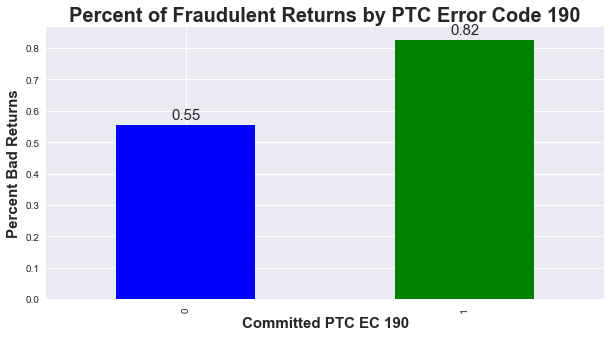

In [18]:
#plot % returns that were bad by filing status
c = PTCAudit3
c = c.groupby(['Ptc_Err_190_Cdb', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='bar',colors=my_colors, figsize=(10,5)) 
plt.title("Percent of Fraudulent Returns by PTC Error Code 190", fontsize=20, fontweight="bold")
ax.set_xlabel("Committed PTC EC 190", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points') 

As we can see from the visuals above, taxpayers receiving an advance on the credit and not including Form 8962 with the tax return) were 27% (82% fraud rate for those with PTC EC 190 vs. 55% rate for those who no PTC EC 190) more likely to file a fraudulent tax return. At this point in time, we can conclude this may be a factor we want to further explore in the future.     

Next, I explored the cycle of the PTC return to see if time had an impact on a return being fraudulent. 

In [19]:
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Cycle_Scored', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c

AUDIT_RESULT,BADRETURN,GOODRETURN,% BAD RETURNS
Cycle_Scored,,,
201504,91.0,76.0,54.491018
201505,123.0,148.0,45.387454
201506,158.0,527.0,23.065693
201507,134.0,115.0,53.815261
201508,170.0,90.0,65.384615
201509,131.0,71.0,64.851485
201510,126.0,77.0,62.068966
201511,106.0,78.0,57.608696
201512,226.0,110.0,67.261905


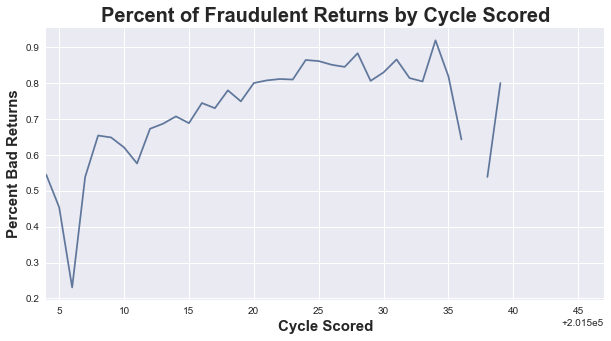

In [20]:
#plot % returns that were bad by cycle scored
c = PTCAudit3
c = c.groupby(['Cycle_Scored', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
#my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='line', figsize=(10,5)) 
plt.title("Percent of Fraudulent Returns by Cycle Scored", fontsize=20, fontweight="bold")
ax.set_xlabel("Cycle Scored", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points')

We can see an increase in the percent of bad returns as the tax filing season progressed. 

Before continuing to explore the relationship between specific variables and fraudulent returns, I examined the distribution of several continuous variables, such as the amount of the Second Lowest Cost Silver Plan (Annl_SLCSP_Prem_Comp). I took this approach in order to get a sense for the spread of the data and to assist me in determining the upper break point for creating categorical variables. 

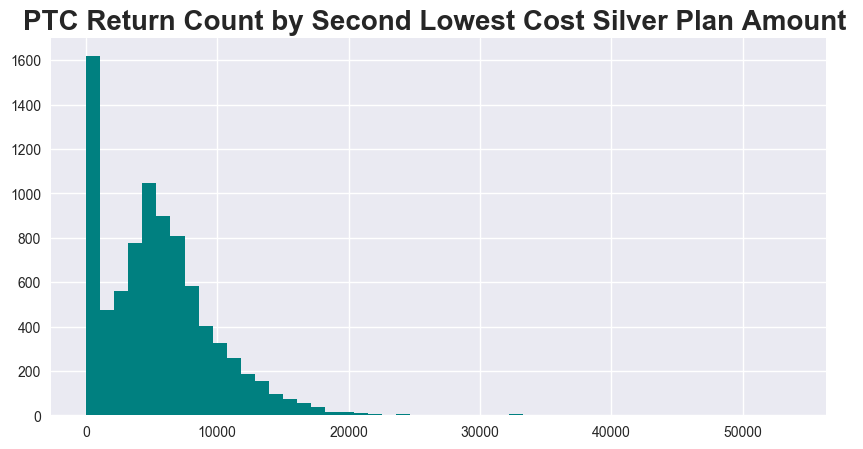

In [21]:
#create histogram of annual SLCSP ---need to see where to break a new categorical variable
fig = plt.figure(figsize=(10,5), dpi=100)
plt.hist(PTCAudit2.Annl_SLCSP_Prem_Comp.dropna(),color=sns.desaturate("teal",1), bins=50)
plt.title("PTC Return Count by Second Lowest Cost Silver Plan Amount ", fontsize=20, fontweight="bold")
ax.set_xlabel("Second Lowet Cost Silver Plan Amount", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    #ax.annotate(str(p.get_height()),xy=(p.get_x(), p.get_height())), xytext=(0,10)
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points') 

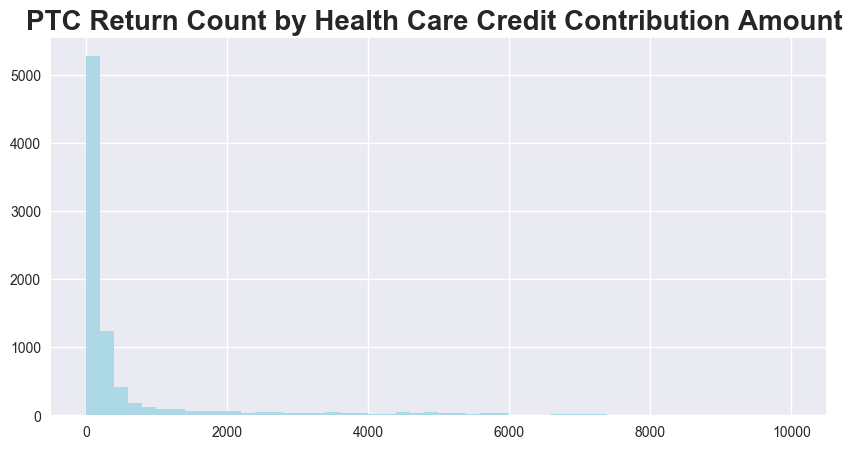

In [22]:
#create histogram of Health Care Contribution Amount ---need to see where to break a new categorical variable
fig = plt.figure(figsize=(10,5), dpi=100)
plt.hist(PTCAudit3.Annual_Contrib_Health_Care_Amt.dropna(),color=sns.desaturate("lightblue",1), bins=50)
plt.title("PTC Return Count by Health Care Credit Contribution Amount ", fontsize=20, fontweight="bold")
ax.set_xlabel("Health Care Credit Contribution Amount Amount", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    #ax.annotate(str(p.get_height()),xy=(p.get_x(), p.get_height())), xytext=(0,10)
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points') 

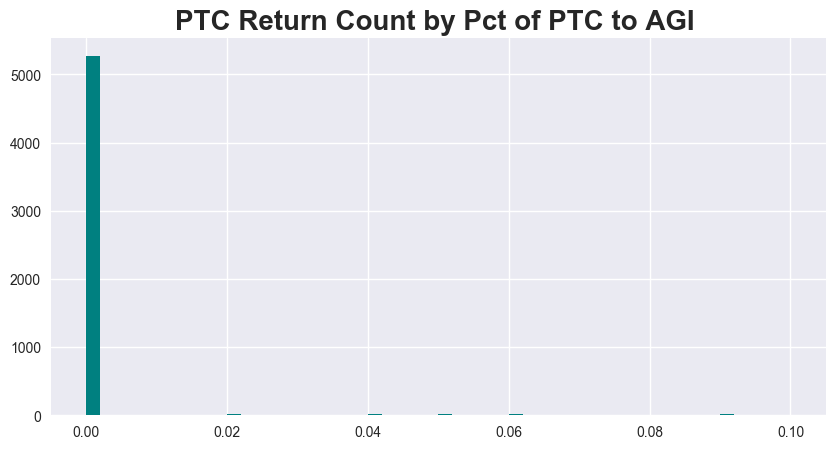

In [23]:
#create histogram of PTC to AGI amount ---need to see where to break a new categorical variable
fig = plt.figure(figsize=(10,5), dpi=100)
plt.hist(PTCAudit3.Ptc_Amt_To_Agi_Pct_Comp.dropna(),color=sns.desaturate("teal",1), bins=50, range=[0,.1])
plt.title("PTC Return Count by Pct of PTC to AGI ", fontsize=20, fontweight="bold")
ax.set_xlabel("Pct PTC to AGI", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    #ax.annotate(str(p.get_height()),xy=(p.get_x(), p.get_height())), xytext=(0,10)
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points') 

In [24]:
f=PTCAudit3 
f = pd.Series(f.Ptc_Amt_To_Agi_Pct_Comp).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['Ptc_Amt_To_Agi_Pct_Comp', 'Frequency']
f.columns

Index(['Ptc_Amt_To_Agi_Pct_Comp', 'Frequency'], dtype='object')

Most of the data for these two continous variables visually seems to trail off at around the 2000 dollar mark. I  chose to create new categorical variables for the various dollar amount continuous variables with a top category cutoff of $2500. I printed the data to check to see if the new variable creation worked. 

In addition, I used by subject matter knowledge to create a new variable; the difference between the advanced credit amount claimed on the tax return and the amount verified by the IRS computer system (verifies calculations) (Aptc_Amt_Comp-Aptc_Amt_From_1040). This amount would tell me how much the taxpayer attempted to lowball their advanced credit amount when filing their tax return (claiming a lesser advanced credit amount would potentially entitle the taxpayer to a refund amount on the tax return). 

In [53]:
#create several new variables for continous variables-- 
#Bal Due 
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] == 0), 'SLCSP_Cat'] = '$0'
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] > 0) & (PTCAudit3['Annl_SLCSP_Prem_Comp'] <= 500), 'SLCSP_Cat'] = '$1 to $500'
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] > 500) & (PTCAudit3['Annl_SLCSP_Prem_Comp'] <= 1000), 'SLCSP_Cat'] = '$501 to $1,000'
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] > 1000) & (PTCAudit3['Annl_SLCSP_Prem_Comp'] <= 1500), 'SLCSP_Cat'] = '$1,001 to $1,500'
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] > 1500) & (PTCAudit3['Annl_SLCSP_Prem_Comp'] <= 2000), 'SLCSP_Cat'] = '$1,501 to $2,000'
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] > 2000) & (PTCAudit3['Annl_SLCSP_Prem_Comp'] <= 2500), 'SLCSP_Cat'] = '$2,001 to $2,500'
PTCAudit3.loc[(PTCAudit3['Annl_SLCSP_Prem_Comp'] > 2500), 'SLCSP_Cat'] = '> $2,500'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] == 0), 'APTC_Cat'] = '$0'
PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] > 0) & (PTCAudit3['Aptc_Amt_From_1040'] <= 500), 'APTC_Cat'] = '$1 to $500'
PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] > 500) & (PTCAudit3['Aptc_Amt_From_1040'] <= 1000), 'APTC_Cat'] = '$501 to $1,000'
PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] > 1000) & (PTCAudit3['Aptc_Amt_From_1040'] <= 1500), 'APTC_Cat'] = '$1,001 to $1,500'
PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] > 1500) & (PTCAudit3['Aptc_Amt_From_1040'] <= 2000), 'APTC_Cat'] = '$1,501 to $2,000'
PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] > 2000) & (PTCAudit3['Aptc_Amt_From_1040'] <= 2500), 'APTC_Cat'] = '$2,001 to $2,500'
PTCAudit3.loc[(PTCAudit3['Aptc_Amt_From_1040'] > 2500), 'APTC_Cat'] = '> $2,500'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] == 0), 'Exc_Aptc_Cat'] = '$0'
PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] > 0) & (PTCAudit3['Exc_Aptc_Amt'] <= 500), 'Exc_Aptc_Cat'] = '$1 to $500'
PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] > 500) & (PTCAudit3['Exc_Aptc_Amt'] <= 1000), 'Exc_Aptc_Cat'] = '$501 to $1,000'
PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] > 1000) & (PTCAudit3['Exc_Aptc_Amt'] <= 1500), 'Exc_Aptc_Cat'] = '$1,001 to $1,500'
PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] > 1500) & (PTCAudit3['Exc_Aptc_Amt'] <= 2000), 'Exc_Aptc_Cat'] = '$1,501 to $2,000'
PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] > 2000) & (PTCAudit3['Exc_Aptc_Amt'] <= 2500), 'Exc_Aptc_Cat'] = '$2,001 to $2,500'
PTCAudit3.loc[(PTCAudit3['Exc_Aptc_Amt'] > 2500), 'Exc_Aptc_Cat'] = '> $2,500'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] == 0), 'Ptc_Cat'] = '$0'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] > 0) & (PTCAudit3['Ptc_Amt_Comp'] <= 500), 'Ptc_Cat'] = '$1 to $500'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] > 500) & (PTCAudit3['Ptc_Amt_Comp'] <= 1000), 'Ptc_Cat'] = '$501 to $1,000'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] > 1000) & (PTCAudit3['Ptc_Amt_Comp'] <= 1500), 'Ptc_Cat'] = '$1,001 to $1,500'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] > 1500) & (PTCAudit3['Ptc_Amt_Comp'] <= 2000), 'Ptc_Cat'] = '$1,501 to $2,000'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] > 2000) & (PTCAudit3['Ptc_Amt_Comp'] <= 2500), 'Ptc_Cat'] = '$2,001 to $2,500'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_Comp'] > 2500), 'Ptc_Cat'] = '> $2,500'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] == 0), 'Recon_Ptc_Cat'] = '$0'
PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] > 0) & (PTCAudit3['Recon_Ptc_Amt'] <= 500), 'Recon_Ptc_Cat'] = '$1 to $500'
PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] > 500) & (PTCAudit3['Recon_Ptc_Amt'] <= 1000), 'Recon_Ptc_Cat'] = '$501 to $1,000'
PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] > 1000) & (PTCAudit3['Recon_Ptc_Amt'] <= 1500), 'Recon_Ptc_Cat'] = '$1,001 to $1,500'
PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] > 1500) & (PTCAudit3['Recon_Ptc_Amt'] <= 2000), 'Recon_Ptc_Cat'] = '$1,501 to $2,000'
PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] > 2000) & (PTCAudit3['Recon_Ptc_Amt'] <= 2500), 'Recon_Ptc_Cat'] = '$2,001 to $2,500'
PTCAudit3.loc[(PTCAudit3['Recon_Ptc_Amt'] > 2500), 'Recon_Ptc_Cat'] = '> $2,500'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] == 0), 'Age_Cat'] = '0'
PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] > 0) & (PTCAudit3['Taxpayer_Age'] <= 20), 'Age_Cat'] = 'Less than 20'
PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] > 20) & (PTCAudit3['Taxpayer_Age'] <= 40), 'Age_Cat'] = '21 to 40'
PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] > 40) & (PTCAudit3['Taxpayer_Age'] <= 60), 'Age_Cat'] = '41 to 60'
PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] > 60) & (PTCAudit3['Taxpayer_Age'] <= 80), 'Age_Cat'] = '61 to 80'
PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] > 80), 'Age_Cat'] = '> 80'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Scnd_Taxpayer_Age'] == 0), 'Scnd_Age_Cat'] = '0'
PTCAudit3.loc[(PTCAudit3['Scnd_Taxpayer_Age'] > 0) & (PTCAudit3['Scnd_Taxpayer_Age'] <= 20), 'Scnd_Age_Cat'] = 'Less than 20'
PTCAudit3.loc[(PTCAudit3['Scnd_Taxpayer_Age'] > 20) & (PTCAudit3['Scnd_Taxpayer_Age'] <= 40), 'Scnd_Age_Cat'] = '21 to 40'
PTCAudit3.loc[(PTCAudit3['Scnd_Taxpayer_Age'] > 40) & (PTCAudit3['Scnd_Taxpayer_Age'] <= 60), 'Scnd_Age_Cat'] = '41 to 60'
PTCAudit3.loc[(PTCAudit3['Scnd_Taxpayer_Age'] > 60) & (PTCAudit3['Scnd_Taxpayer_Age'] <= 80), 'Scnd_Age_Cat'] = '61 to 80'
PTCAudit3.loc[(PTCAudit3['Scnd_Taxpayer_Age'] > 80), 'Scnd_Age_Cat'] = '> 80'
PTCAudit3['APTC_Lowball'] = (PTCAudit3['Aptc_Amt_Comp']-PTCAudit3['Aptc_Amt_From_1040'])/PTCAudit3['Aptc_Amt_From_1040']
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] == 0), 'Annual_Contrib_Cat'] = '$0'
PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] > 0) & (PTCAudit3['Annual_Contrib_Health_Care_Amt'] <= 500), 'Annual_Contrib_Cat'] = '$1 to $500'
PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] > 500) & (PTCAudit3['Annual_Contrib_Health_Care_Amt'] <= 1000), 'Annual_Contrib_Cat'] = '$501 to $1,000'
PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] > 1000) & (PTCAudit3['Annual_Contrib_Health_Care_Amt'] <= 1500), 'Annual_Contrib_Cat'] = '$1,001 to $1,500'
PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] > 1500) & (PTCAudit3['Annual_Contrib_Health_Care_Amt'] <= 2000), 'Annual_Contrib_Cat'] = '$1,501 to $2,000'
PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] > 2000) & (PTCAudit3['Annual_Contrib_Health_Care_Amt'] <= 2500), 'Annual_Contrib_Cat'] = '$2,001 to $2,500'
PTCAudit3.loc[(PTCAudit3['Annual_Contrib_Health_Care_Amt'] > 2500), 'Annual_Contrib_Cat'] = '> $2,500'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] == 0), 'Ptc_toAGI_Cat'] = '0'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] > 0) & (PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] <= 5), 'Ptc_toAGI_Cat']  = '0 to 5'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] > 5) & (PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] <= 10), 'Ptc_toAGI_Cat'] = '5 to 10'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] > 10) & (PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] <= 15), 'Ptc_toAGI_Cat'] = '10 to 15'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] > 15) & (PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] <= 20), 'Ptc_toAGI_Cat'] = '15 to 20'
PTCAudit3.loc[(PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] > 20), 'Ptc_toAGI_Cat'] = '> 20'
PTCAudit3

PTCAudit3.loc[(PTCAudit3['DISP_CD'] > 0) & (PTCAudit3['DISP_CD'] < 3), 'BAD_RETURN'] = "BAD"
PTCAudit3.loc[(PTCAudit3['DISP_CD'] > 2), 'BAD_RETURN'] = "GOOD"
PTCAudit3

PTCAudit3.loc[(PTCAudit3['DISP_CD'] > 0) & (PTCAudit3['DISP_CD'] < 3), 'BAD_RETURN_NUM'] = 1
PTCAudit3.loc[(PTCAudit3['DISP_CD'] > 2), 'BAD_RETURN_NUM'] = 0
PTCAudit3


,AGIFinal,AUDIT_RESULT,Agi_Comp,Annl_SLCSP_Prem_Comp,Annual_Contrib_Health_Care_Amt,Aptc_Amt_Comp,Aptc_Amt_From_1040,Bal_Due_Amt_Comp,Bal_Due_Amt_CompFinal,Bod_Cd,City,Current_Ty_Exemptions,Cycle_Scored,DISP_CD,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,Dependent_Ind,Exc_Aptc_Amt,Exc_Aptc_Lim_Amt,Exposure_AmtFinal,Family_Size,FilStatFinal,Filing_Status,First_Time_Filer,Fpl_Pct_CompFinal,Hardship_Ind,Household_Income_Amt,Idt_Cond,PTC_Scored_Count,Prior_Ty_Exemptions,Prior_Ty_Filing_Status,Prisoner_Ind,Ptc_Amt_Comp,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ptc_Ind,Ptc_Magi_Amt,Recon_Ptc_Amt,Recon_Ptc_Amt_Sum,Sch_C_Prof_Loss_AmtFinal,Sch_C_To_Agi_Pct_Comp,Scnd_Taxpayer_Age,State,Taxpayer_Age,Tot_Income,tin,SLCSP_Cat,APTC_Cat,Exc_Aptc_Cat,Ptc_Cat,Recon_Ptc_Cat,Age_Cat,Scnd_Age_Cat,APTC_Lowball,Annual_Contrib_Cat,Ptc_toAGI_Cat,BAD_RETURN,BAD_RETURN_NUM
0,"7-$50,001 to $75,000",BADRETURN,63447,5805,0,0,0,-3389,"1- Equal or Less than -$2,500",WI,JAMESTOWN,2,201514,4,0,0,0,0,0,0,0,1,0,0,0.0,0,0,"11- $3,500 or more",0,2-MFJ,2,0.0,5- Greater than 400%,0,0,X,1,2,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,62,RI,65,63447,2077793,"> $2,500",$0,$0,$0,$0,61 to 80,61 to 80,NaN,$0,0,GOOD,0.0
1,"5-$30,001 to $40,000",BADRETURN,31143,5700,2697,0,0,-3592,"1- Equal or Less than -$2,500",WI,NORTH LAS VEGAS,1,201517,4,0,0,0,0,0,0,0,0,0,0,0.0,0,0,"11- $3,500 or more",1,1-Single,1,0.0,3- 201% to 300%,0,31143,X,1,1,1.0,0,3003,9,0,0,0,0,0,0,0,0,1,0,1,31143,3003,3003,6- $0,0.00,0,NV,59,31143,2136992,"> $2,500",$0,$0,"> $2,500","> $2,500",41 to 60,0,NaN,"> $2,500",5 to 10,GOOD,0.0
2,"8-$75,001 to $100,000",BADRETURN,99074,8940,0,0,0,35057,"9- $2,500 or more",SB,KITTERY POINT,1,201535,4,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"10- $2,500 to $3,499",0,3-MFS,3,0.0,5- Greater than 400%,0,0,X,1,2,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,0,ME,53,108085,2143790,"> $2,500",$0,$0,$0,$0,41 to 60,0,NaN,$0,0,GOOD,0.0
3,"7-$50,001 to $75,000",BADRETURN,58231,12852,0,0,0,3671,"9- $2,500 or more",WI,MANCHESTER,2,201528,4,0,0,0,0,0,0,0,1,0,0,0.0,0,0,"11- $3,500 or more",0,2-MFJ,2,0.0,4- 301% to 400%,0,0,X,1,2,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,58,NH,63,58231,2205691,"> $2,500",$0,$0,$0,$0,61 to 80,41 to 60,NaN,$0,0,GOOD,0.0
4,"7-$50,001 to $75,000",BADRETURN,62656,11610,0,0,0,-366,4- -$499 to -$1,WI,MEREDITH,2,201524,4,0,0,0,0,0,0,0,1,0,0,0.0,0,0,"10- $2,500 to $3,499",0,2-MFJ,2,0.0,5- Greater than 400%,0,0,X,1,2,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,48,NH,51,62656,2349124,"> $2,500",$0,$0,$0,$0,41 to 60,41 to 60,NaN,$0,0,GOOD,0.0
5,"5-$30,001 to $40,000",BADRETURN,36472,5301,2746,0,0,-3420,"1- Equal or Less than -$2,500",WI,FRANKLIN,2,201520,4,0,0,0,0,0,0,0,0,0,0,0.0,0,0,"11- $3,500 or more",2,2-MFJ,2,0.0,3- 201% to 300%,0,36472,X,1,2,2.0,0,3240,8,0,0,0,0,0,0,0,0,1,0,1,36472,3240,3240,6- $0,0.00,44,NH,39,36472,2402689,"> $2,500",$0,$0,"> $2,500","> $2,500",21 to 40,41 to 60,NaN,"> $2,500",5 to 10,GOOD,0.0
6,"9-$100,000",GOODRETURN,100440,8952,0,0,0,3930,"9- $2,500 or more",WI,MERRIMACK,3,201523,2,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"11- $3,500 or more",0,2-MFJ,2,0.0,5- Greater than 400%,0,0,X,1,4,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,36,NH,36,100440,2594841,"> $2,500",$0,$0,$0,$0,21 to 40,21 to 40,NaN,$0,0,BAD,1.0
7,"8-$75,001 to $100,000",BADRETURN,83424,10560,0,0,0,-2655,"1- Equal or Less than -$2,500",SB,HAMPTON,3,201527,4,0,0,0,0,0,0,0,1,0,0,1.0,0,0,"11- $3,500 or more",0,2-MFJ,2,0.0,5- Greater than 400%,0,0,X,1,4,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6- $0,0.00,45,NH,46,83424,2613420,"> $2,500",$0,$0,$0,$0,41 to 60,41 to 60,NaN,$0,0,GOOD,0.0
8,"6-$40,001 to $50,000",GOODRETURN,46110,14568,0,0,0,-2391,"2- -$2,499 to -$1,500",WI,EXETER,1,201528,2,0,0,0,0,0,0,0,1,0,0,0.0,0,0,"11- $3,50

In [26]:
f=PTCAudit3 
f = pd.Series(f.Ptc_toAGI_Cat).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['Ptc_toAGI_Cat', 'Frequency']
print (f)

  Ptc_toAGI_Cat  Frequency
0             0       5274
1        0 to 5       1087
2      10 to 15        166
3      15 to 20        174
4       5 to 10        216
5          > 20        622


In [27]:
f=PTCAudit3 
f = pd.Series(f.APTC_Lowball).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['APTC_Lowball', 'Frequency']
print (f)

    APTC_Lowball  Frequency
0      -1.000000         86
1      -0.964889          1
2      -0.958333          1
3      -0.916667          1
4      -0.899471          1
5      -0.750552          2
6      -0.654514          1
7      -0.533333          1
8      -0.500000          1
9      -0.200000          1
10     -0.125000          1
11     -0.050445          1
12      0.000000       2665
13      0.022635          1
14      0.036735          1
15      0.066250          1
16      0.090909          2
17      0.111111          1
18      0.160256          1
19      0.189427          1
20      0.200000          4
21      5.089172          1
22      7.000000          1
23      9.000000          1
24     11.000000          1
25           inf         16


As we have very few instances in which the APTC lowball amount was not null or =0, I decided to exclude this variable from further analysis. 

# 2. Monetary Factors
I explored the Annual Contribution Healthcare Amount to see if it had an impact on fraudulent PTC returns.   

In [28]:
#crosstab of ACHCA and whether return bad or good 
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Annual_Contrib_Cat', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c.head

<bound method NDFrame.head of AUDIT_RESULT        BADRETURN  GOODRETURN  % BAD RETURNS
Annual_Contrib_Cat                                      
$0                       4084         938      81.322182
$1 to $500               1016         757      57.304005
$1,001 to $1,500          121         106      53.303965
$1,501 to $2,000           90          57      61.224490
$2,001 to $2,500           91          31      74.590164
$501 to $1,000            244         183      57.142857
> $2,500                  317         403      44.027778>

C:\Users\Travis\Anaconda3\lib\site-packages\pandas\plotting\_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


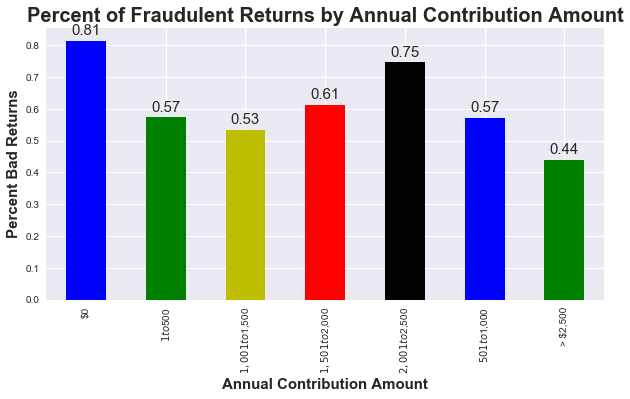

In [29]:
#plot % returns that were bad by ACA
c = PTCAudit3
c = c.groupby(['Annual_Contrib_Cat', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='bar',colors=my_colors, figsize=(10,5)) 
plt.title("Percent of Fraudulent Returns by Annual Contribution Amount", fontsize=20, fontweight="bold")
ax.set_xlabel("Annual Contribution Amount", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points')  

In this case, there are higher fraud rates for PTC returns with no Health Care Contribution amount or having an amount between 2,100 and 2,500 dollars. This could be because those filing fraudulent returns are not aware many returns would have a non-zero number claimed for this amount.  

Next, I explored the percentage of Premium Tax Credit to the Adjusted Gross Income of the taxpayer. As PTC is a low-income credit, there could be 

In [30]:
#crosstab of % PTC to AGI and whether return bad or good 
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Ptc_toAGI_Cat', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c.head

<bound method NDFrame.head of AUDIT_RESULT   BADRETURN  GOODRETURN  % BAD RETURNS
Ptc_toAGI_Cat                                      
0                   4207        1067      79.768677
0 to 5               576         511      52.989880
10 to 15             118          48      71.084337
15 to 20             120          54      68.965517
5 to 10              145          71      67.129630
> 20                 372         250      59.807074>

C:\Users\Travis\Anaconda3\lib\site-packages\pandas\plotting\_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


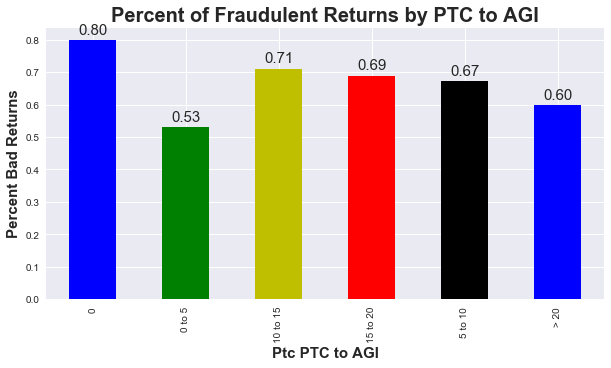

In [31]:
#plot % returns that were bad by Pct of PTC to AGI
c = PTCAudit3
c = c.groupby(['Ptc_toAGI_Cat', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='bar',colors=my_colors, figsize=(10,5)) 
plt.title("Percent of Fraudulent Returns by PTC to AGI", fontsize=20, fontweight="bold")
ax.set_xlabel("Ptc PTC to AGI", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points')

The chart above shows that, as the percent of PTC to AGI goes over 5, fraud rates increase. Next, I want to explored the relationship between % PTC to AGI and fraud using a scatterplot.

C:\Users\Travis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


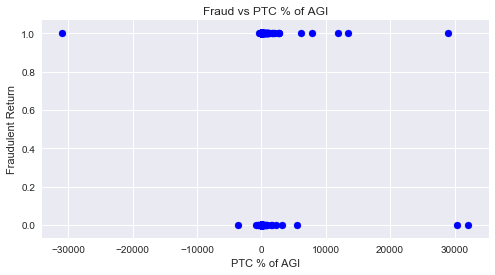

In [54]:
#scatterplot of % PTC to AGI by fraud 
plt.figure()
plt.scatter(PTCAudit3.Ptc_Amt_To_Agi_Pct_Comp.values,PTCAudit3.BAD_RETURN_NUM.values, color='b')
plt.legend()
plt.xlabel('PTC % of AGI')
plt.ylabel('Fraudulent Return')
plt.title('Fraud vs PTC % of AGI');

In [43]:
import scipy.stats as stats
stats.normaltest(PTCAudit3.Ptc_Amt_To_Agi_Pct_Comp)

NormaltestResult(statistic=18888.315939538366, pvalue=0.0)

As I am comparing a continous (% PTC of AGI) and binary variable (Good vs. Bad Return), I'll need to use a Point-Biserial Correlation. First, I need to convert both variables from float to integer.  

In [61]:
PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'] = PTCAudit3['Ptc_Amt_To_Agi_Pct_Comp'].astype('int')
PTCAudit3['Sch_C_To_Agi_Pct_Comp'] = PTCAudit3['Sch_C_To_Agi_Pct_Comp'].astype('int')
PTCAudit3['BAD_RETURN_NUM'] = PTCAudit3['BAD_RETURN_NUM'].astype('int')

In [62]:
pd.set_option('display.max_rows', 100)
PTCAudit3. dtypes

AGIFinal                           object
AUDIT_RESULT                       object
Agi_Comp                            int64
Annl_SLCSP_Prem_Comp                int64
Annual_Contrib_Health_Care_Amt      int64
Aptc_Amt_Comp                       int64
Aptc_Amt_From_1040                  int64
Bal_Due_Amt_Comp                    int64
Bal_Due_Amt_CompFinal              object
Bod_Cd                             object
City                               object
Current_Ty_Exemptions               int64
Cycle_Scored                        int64
DISP_CD                             int64
Ddb_Ptc_900_Cdb                     int64
Ddb_Ptc_901_Cdb                     int64
Ddb_Ptc_902_Cdb                     int64
Ddb_Ptc_903_Cdb                     int64
Ddb_Ptc_904_Cdb                     int64
Ddb_Ptc_910_Cdb                     int64
Ddb_Ptc_911_Cdb                     int64
Ddb_Ptc_912_Cdb                     int64
Ddb_Ptc_913_Cdb                     int64
Ddb_Ptc_914_Cdb                   

In [59]:
stats.pointbiserialr(PTCAudit3.Ptc_Amt_To_Agi_Pct_Comp, PTCAudit3.BAD_RETURN_NUM)

PointbiserialrResult(correlation=0.010927791533144061, pvalue=0.31552673724366831)

According to the results of the Point-Biserial Correlation, it appears there is a non-significant weak positive correlation between the % of PTC to AGI and a fraudulent return.

Next, I want to explore the relationship between Adjusted Gross Income and fraudulent returns.

In [66]:
#crosstab of % PTC to AGI and whether return bad or good 
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['AGIFinal', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c.head

<bound method NDFrame.head of AUDIT_RESULT            BADRETURN  GOODRETURN  % BAD RETURNS
AGIFinal                                                    
1-Equal or less than 0         38          28      57.575758
2-$1 to $10,000               316         271      53.833049
3-$10,001 to $20,000         1283         732      63.672457
4-$20,001 to $30,000          499         331      60.120482
5-$30,001 to $40,000          245         135      64.473684
6-$40,001 to $50,000          389         157      71.245421
7-$50,001 to $75,000         1228         419      74.559806
8-$75,001 to $100,000         880         165      84.210526
9-$100,000                   1085         237      82.072617>

Those with high income were more likely to file a fraudulent PTC return, with the fraud rate increasing nearly 30% between those that had an income below 10,000 to those that had income greater than $100,000 (82%-53%). 

In [71]:
stats.pointbiserialr(PTCAudit3.Agi_Comp, PTCAudit3.BAD_RETURN_NUM)

PointbiserialrResult(correlation=-0.085733478247800018, pvalue=3.0530959225110498e-15)

According to the results of the Point-Biserial Correlation, it appears there is a non-significant weak nega correlation between the % of PTC to AGI and a fraudulent return.

In [ ]:
#crosstab of family size and whether return bad or good 
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Family_Size', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c.head

In [ ]:
#plot % returns that were bad by family size
c = PTCAudit3
c = c.groupby(['Family_Size', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='bar',colors=my_colors, figsize=(10,10)) 
plt.title("Percent of Fraudulent Returns by Family Size", fontsize=20, fontweight="bold")
ax.set_xlabel("Family Size", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points')  

Family sizes of 0 and above 6 members had higher fraud rates than did other family member sizes. 

In [ ]:
#crosstab of Age and whether return bad or good 
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Age_Cat', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c.head  

In [ ]:
#plot % returns that were bad by age
c = PTCAudit3
c = c.groupby(['Age_Cat', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='bar',colors=my_colors, figsize=(10,10)) 
plt.title("Percent of Fraudulent Returns by Primary Age", fontsize=20, fontweight="bold")
ax.set_xlabel("Primary Age", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points')

Returns filed with a PTC claim where the primary taxpayer on the return was over 80 years old were more 16% more likely than any other group (and 29% more likely than those 21 to 40) to be fraudulent. 

In [ ]:
#crosstab of State and whether return bad or good 
c = PTCAudit3
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['State', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c

In [ ]:
#plot % returns that were bad by age
c = PTCAudit3
c = c.groupby(['State', 'AUDIT_RESULT']).size()
c = c.unstack('AUDIT_RESULT')
my_colors = list(islice(cycle(['b', 'g', 'y', 'r', 'k']), None, len(c)))
ax=(c.BADRETURN / (c.BADRETURN + c.GOODRETURN)).plot(kind='bar',colors=my_colors, figsize=(20,10)) 
plt.title("Percent of Fraudulent Returns by State", fontsize=20, fontweight="bold")
ax.set_xlabel("State", fontsize=15, fontweight="bold")
ax.set_ylabel("Percent Bad Returns", fontsize=15, fontweight="bold") 
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='center', xytext=(0, 10), fontsize=15, textcoords='offset points')

Though the chart is crowded, the table above allows us to see that California has one of the highest fraudulent return percentages (78%) while also having one of the larger state volumes among the PTC return dataset. What I now want to do is see the combined impact of these three variables. 

In [ ]:
#create several new variables for continous variables-- 
#Bal Due 
PTCAudit3.loc[(PTCAudit3['Taxpayer_Age'] > 60) & (PTCAudit3['State'] == 'CA'), 'Combo_Var_Ind'] = 1
PTCAudit3

In [ ]:
#replaced missing values for combo variable with 0
PTCAudit4=PTCAudit3.fillna(0)
PTCAudit4.isnull().sum()
PTCAudit4.head()

In [ ]:
#distributCombo Variable
f=PTCAudit4 
f = pd.Series(f.Combo_Var_Ind).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['Combo_Var_Ind', 'Frequency']
print (f)

In [ ]:
#crosstab of Combo Variable and whether return bad or good 
c = PTCAudit4
c = c[(c.AUDIT_RESULT == 'GOODRETURN') | (c.AUDIT_RESULT == 'BADRETURN')]
c = c.groupby(['Combo_Var_Ind', 'AUDIT_RESULT']).size()
c = c.unstack()
c = c.fillna(0)
c['% BAD RETURNS'] = c['BADRETURN']/(c['GOODRETURN']+c['BADRETURN'])*100
c

As you can see from the charts, taxpayers over 80 who live in California are more 16% (86%-70%) more likely to file fraudulent PTC returns than other taxpayers claiming the PTC. Relationships such as these will be next steps to explore during inferential and more advanced statistical methods.  

# Conclusions and Next Steps
After conducting an initial exploratory analysis on the dataset, I was able to identify several input variable I feel may have an impact on filing a fraudulent PTC return, including a taxpayer's family size, age, and whether or not they attach a Form 8962 with their tax return. In addition, I was able to identify that a taxpayer over 60 who lives in California is 16% more likely to file a fraudulent PTC return than other taxpayers who file PTC returns. In my next submission , I will use inferential statistics to test the effect these input variables have on the filing of fraudulent PTC returns. My hypothesis at this time is that state, age, and failing to attach a Form 8962 with the tax return will have a significant effect on the filing of PTC returns. I may chose to examine other input variables as well. 